In [124]:
from selenium import webdriver 
from selenium.webdriver.common.by import By 
from selenium.webdriver.support.ui import WebDriverWait 
from selenium.webdriver.support import expected_conditions as EC 
from selenium.common.exceptions import TimeoutException

In [7]:
import pandas as pd
import plotly.express as px

In [126]:
option = webdriver.ChromeOptions()
option.add_argument(" — incognito")

In [127]:
def scrape():
    table = browser.find_element_by_class_name('ch-exposure-sites-search-form')
    df = pd.read_html(table.get_attribute('innerHTML'))
    return df[0]

In [128]:
browser = webdriver.Chrome(executable_path='/Users/ikiko/Desktop/chromedriver', chrome_options=option)

<ipython-input-128-20b4a8144752>:1: DeprecationWarning:

use options instead of chrome_options



In [129]:
browser.get("https://www.coronavirus.vic.gov.au/exposure-sites")

In [130]:
elements = scrape()

In [131]:
nextpagebutton1 = browser.find_element_by_class_name('rpl-pagination__list').find_elements_by_class_name('rpl-pagination__step')[1]
nextpagebutton1.click()

In [132]:
elements = pd.concat([elements, scrape()])

In [133]:
nextpagebutton2 = browser.find_element_by_class_name('rpl-pagination__list').find_elements_by_class_name('rpl-pagination__step')[2]
nextpagebutton2.click()

In [134]:
elements = pd.concat([elements, scrape()])

In [135]:
nextpagebutton_continuous = browser.find_element_by_class_name('rpl-pagination__list').find_elements_by_class_name('rpl-pagination__step')[3]
i = 3
while i <= 20:
    nextpagebutton_continuous.click()
    elements = pd.concat([elements, scrape()])
    nextpagebutton_continuous = browser.find_element_by_class_name('rpl-pagination__list').find_elements_by_class_name('rpl-pagination__step')[3]
    i = i + 1


In [136]:
nextpagebutton_last = browser.find_element_by_class_name('rpl-pagination__list').find_elements_by_class_name('rpl-pagination__step')[4]
nextpagebutton_last.click()
elements = pd.concat([elements, scrape()])

In [137]:
browser.close()

In [138]:
len(elements)

633

In [139]:
elements = elements.drop(columns=['Suburb.1', 'Site.1', 'Notes.1', 'Health advice.1'])

In [140]:
elements = elements.reset_index()
elements = elements.drop(columns=['index'])

In [141]:
elements['date_exposure'] = elements['Exposure period'].apply(lambda x: x.split(' ')[2])
elements['date_added'] = elements['Date added'].apply(lambda x: x.split(' ')[2])

In [142]:
elements = elements.drop_duplicates()

Date not available for some... showing up as 'Data' in date_added column 

In [143]:
elements = elements[elements.date_added != "Data"]

In [144]:
elements.date_added = pd.to_datetime(elements.date_added, dayfirst=True)
elements.date_exposure = pd.to_datetime(elements.date_exposure, dayfirst=True)
elements['tier'] = elements['Health advice'].apply(lambda x: x.split(' ')[3])

In [145]:
# filter weird outliers
elements = elements[elements.date_exposure < '2021-10-01']

In [146]:
import plotly.express as px

In [147]:
fig = px.scatter(elements, y="date_added", x="date_exposure", opacity=0.5, hover_data=['Suburb', 'Site'], template='plotly_dark')
fig.update_traces(marker_size = 20)

In [148]:
import plotly.graph_objects as go

fig_heat = px.density_heatmap(elements, y="date_added", x="date_exposure", hover_data=['Suburb', 'Site'], 
                         template='plotly_dark', nbinsx=20, nbinsy=20, color_continuous_scale='viridis'
                        , title = 'Exposure site counts by date added')
fig_heat.add_vline('2021-05-27')
fig_heat.add_hline('2021-05-27')
fig_heat.add_annotation(x = '2021-05-27', y = '2021-05-27', text='lockdown', xanchor='left', ax=10, ay=20)
fig_heat.update_layout(xaxis_title = "Exposure Date", yaxis_title='Date Added')


In [149]:
px.strip(elements, y="date_exposure", template='plotly_dark')

In [150]:
elements['date_delay'] = elements.date_added - elements.date_exposure

In [151]:
elements.date_delay = elements.date_delay.dt.days

In [152]:
fig_delay = px.histogram(elements, x='date_delay', template='plotly_dark', title='Reporting delay (difference between reporting and exposure time)')
fig_delay.add_vline(x = elements.date_delay.describe()['50%'], annotation_text='median')


In [157]:
fig_date = px.histogram(elements.sort_values(by='tier'), x='date_exposure', template='plotly_dark', color='tier', color_discrete_sequence=px.colors.qualitative.Set1[0:3], title='Exposure time')
fig_date.add_vline(x='2021-05-27')
fig_date.add_annotation(x = '2021-05-27', y= 40, text='lockdown', xanchor='left', ax=10, ay=20)

fig_date.update_layout(
    bargap=0.2, # gap between bars of adjacent location coordinates
)

fig_date.update_xaxes(
    tickangle = 60, 
    nticks = 10
)

fig_date.show()

In [158]:
elements.date_exposure.describe()

<ipython-input-158-767a3a2e7ad0>:1: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.



count                     298
unique                     17
top       2021-05-22 00:00:00
freq                       52
first     2021-05-12 00:00:00
last      2021-05-29 00:00:00
Name: date_exposure, dtype: object

In [159]:
fig_heat.show()
fig_date.show()
fig_delay.show()

In [160]:
elements.to_csv('scraped_data.csv')

In [161]:
len(elements)

298

# Switching to the API

In [112]:
import requests as req
import pandas as pd
import plotly.express as px
import datetime as dt

In [113]:
import datetime

In [114]:
resp = req.get('https://discover.data.vic.gov.au/api/3/action/datastore_search?resource_id=afb52611-6061-4a2b-9110-74c920bede77')

In [115]:
base = 'https://discover.data.vic.gov.au'
resp = req.get('https://discover.data.vic.gov.au/api/3/action/datastore_search?resource_id=afb52611-6061-4a2b-9110-74c920bede77')
next_link = resp.json()['result']['_links']['next']
records = resp.json()['result']['records']
total = resp.json()['result']['total']
while len(records) < total:
    resp = req.get(base+next_link)
    records.extend(resp.json()['result']['records'])
#     print(resp.json()['result']['_links']['next'])
    next_link = resp.json()['result']['_links']['next']
    

In [116]:
len(records)

364

In [117]:
width = 580

In [118]:
df_official = pd.DataFrame(records)

In [119]:
df_official['tier'] = df_official.Advice_title.apply(lambda x: x.split(' ')[1])

In [120]:
df_official.Added_date_dtm = pd.to_datetime(df_official.Added_date_dtm, dayfirst=True)
df_official.Exposure_date_dtm = pd.to_datetime(df_official.Exposure_date_dtm, dayfirst=True)

In [121]:
fig_date = px.histogram(df_official.sort_values(by='tier'), 
                        x='Exposure_date_dtm', template='plotly_dark', 
                        color='tier', color_discrete_sequence=px.colors.qualitative.Set1[0:3], 
                        title='Exposure date categorised by tier')
fig_date.add_vline(x=dt.datetime(2021, 5, 27, 12, 0))
fig_date.add_annotation(x = '2021-05-27', y= 40, text='lockdown', xanchor='left', ax=10, ay=20)

fig_date.update_layout(
    bargap=0.2, # gap between bars of adjacent location coordinates
    xaxis_title = "Exposure date", 
    yaxis_title = "Number of exposure sites", 
    width = width
)


fig_date.update_xaxes(
    tickangle = 60, 
    nticks = 10,
    range=[df_official.Exposure_date_dtm.min() - dt.timedelta(hours=12), df_official.Added_date_dtm.max() + dt.timedelta(hours=12)]
)

fig_date.show()

In [136]:

df_official['date_delay'] = df_official.Added_date_dtm - df_official.Exposure_date_dtm
df_official.date_delay = df_official.date_delay.dt.days

fig_delay = px.histogram(df_official, x='date_delay', template='plotly_dark',
                         color_discrete_sequence=[px.colors.qualitative.Set1[1]],
                         title='Reporting delay (reporting time minus exposure time)')
fig_delay.add_vline(x = df_official.date_delay.describe()['50%'], annotation_text='median')
fig_delay.update_layout(width=width, 
                       xaxis_title = "Delay between exposure and report", 
                       yaxis_title = "Number of exposure sites")

In [123]:
nbinsy = (df_official.Added_date_dtm.max() - df_official.Exposure_date_dtm.min()).days + 1
nbinsx = (df_official.Added_date_dtm.max() - df_official.Exposure_date_dtm.min()).days + 1

fig_heat = px.density_heatmap(df_official, y="Added_date_dtm", x="Exposure_date_dtm", 
                         template='plotly_dark', nbinsx=nbinsx, 
                              nbinsy=nbinsy, color_continuous_scale='viridis',
                              title = 'Exposure site counts by date added')
fig_heat.add_vline(x=dt.datetime(2021, 5, 27, 12, 0))
fig_heat.add_hline(y=dt.datetime(2021, 5, 27, 12, 0))
fig_heat.add_annotation(x = '2021-05-27', y = '2021-05-27', text='lockdown', xanchor='left', ax=10, ay=20)
fig_heat.update_layout(xaxis_title = "Exposure Date", 
                       xaxis_tickangle = 60, xaxis_side = 'bottom', 
                       yaxis_title='Date Added',
                       xaxis_nticks=nbinsx//2,
                       width=width, 
                       plot_bgcolor=px.colors.sequential.Viridis[0], 
                       xaxis_showgrid=False,
                       yaxis_showgrid=False, 
                       xaxis_range=[df_official.Exposure_date_dtm.min()- dt.timedelta(hours=12), df_official.Added_date_dtm.max() + dt.timedelta(hours=12)], 
                       yaxis_range=[df_official.Exposure_date_dtm.min()- dt.timedelta(hours=12), df_official.Added_date_dtm.max() + dt.timedelta(hours=12)]
                       )

# pretty but useless 

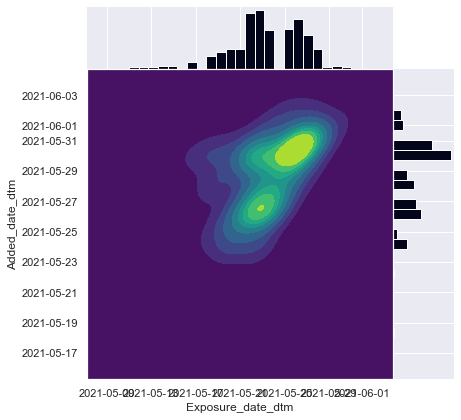

In [110]:
import seaborn as sns
sns.set_theme(style="darkgrid")

g = sns.JointGrid(data=df_official, x="Exposure_date_dtm", y="Added_date_dtm", space=0)
g.plot_joint(sns.kdeplot,
             fill=True, 
             thresh=0, levels=10, cmap="viridis")
g.plot_marginals(sns.histplot, color="#03051A", alpha=1, bins=nbinsx)

In [111]:
df_official.to_csv('data_from_api.csv')

# mappin'

Postcode data from: https://www.corra.com.au/australian-postcode-location-data/

In [257]:
df_loc = pd.read_csv('Australian_Post_Codes_Lat_Lon.csv')
df_loc = df_loc.rename(columns={'postcode':'Site_postcode'})
df_loc.Site_postcode = df_loc.Site_postcode.astype('string')

In [258]:
a = df_official.groupby(['Exposure_date_dtm', 'Site_postcode'])['_id'].count().reset_index()
a.head()
df_map = a.merge(df_loc, on=['Site_postcode'], how='left')
df_map['days_in_the_past'] = df_map.Exposure_date_dtm.subtract(dt.datetime.today()).dt.days

In [291]:
fig_map = px.scatter_mapbox(df_map,lat='lat', lon='lon', hover_data=['Site_postcode', '_id'], mapbox_style='carto-positron', 
                  color_discrete_sequence=px.colors.qualitative.Set1, 
                  opacity=0.6, title='Exposure sites in space and time',
                  size='_id', 
                color='days_in_the_past', height=1100, width=1100, center={'lat':-37.45,'lon':144.995})
fig_map.update_layout(
    coloraxis_colorbar_title='Days from today')
fig_map.show()

In [274]:
import kaleido as kd

In [280]:
fig_map.write_image('map.jpg', scale=5)

In [ ]:
fig_map